This Notebook will store cleaned data in a SQLite database, and explore plotting.

Importing libraries:

In [119]:
import pandas as pd 
import matplotlib.pyplot as plt
import sqlite3
import tabulate

Importing cleaned data:

In [120]:
air_df = pd.read_csv("Air_quality_by_CD.csv")
tree_df = pd.read_csv("tree_summary_by_cb.csv")
boro_df = pd.read_csv("borough_tree.csv")

Creating a SQLite database:

In [121]:
#Create SQLite database and tables
conn = sqlite3.connect("air_and_tree.db")
cursor = conn.cursor()

#create table air
cursor.execute("""
CREATE TABLE IF NOT EXISTS air (
    id TEXT NOT NULL,
    Name TEXT NOT NULL,
    Geo_Join_ID TEXT PRIMARY KEY,
    Time_Period TEXT NOT NULL,
    Data_Value REAL NOT NULL
);        
""")

#create table tree
cursor.execute(""" 
CREATE TABLE IF NOT EXISTS tree (
    tree_id TEXT NOT NULL,
    cb_num TEXT PRIMARY KEY,
    dbh_mean REAL NOT NULL,
    dbh_max INTEGER NOT NULL,
    tree_count INTEGER NOT NULL,
    avg_health_score REAL NOT NULL, 
    unique_species INTEGER NOT NULL
);             
""")

#insert data into tables
air_df.to_sql("air", conn, if_exists="replace", index=False)
tree_df.to_sql("tree", conn, if_exists="replace", index=False)

#verify data was inserted
print("Air Data Table: \n")
print(pd.read_sql_query("SELECT * FROM air LIMIT 5", conn))

print("Tree Data Table: \n")
print(pd.read_sql_query("SELECT * FROM tree LIMIT 5", conn))



Air Data Table: 

   id  Geo_Join_ID          Time_Period                    Name  Data_Value  \
0   1        304.0          Summer 2015  Nitrogen dioxide (NO2)        15.5   
1   2        410.0       Winter 2015-16  Nitrogen dioxide (NO2)        22.5   
2   3        301.0          Summer 2015  Nitrogen dioxide (NO2)        17.0   
3   4        409.0          Summer 2015  Nitrogen dioxide (NO2)        14.4   
4   5        304.0  Annual Average 2015  Nitrogen dioxide (NO2)        20.3   

  Measure_Info  Indicator_ID  
0          ppb           375  
1          ppb           375  
2          ppb           375  
3          ppb           375  
4          ppb           375  
Tree Data Table: 

   tree_id  cb_num  tree_count  avg_health_score  dbh_mean  dbh_max  \
0        1     101        2297            2.7101     7.096       88   
1        2     102        4833            2.6739     8.898       33   
2        3     103        4709            2.7084     8.449       32   
3        4     104

In [122]:
#Create table boro 

cursor.execute("""
CREATE TABLE IF NOT EXISTS boro (
    boroname TEXT PRIMARY KEY,
    unique_species INTEGER NOT NULL,
    avg_dbh REAL NOT NULL,
    total_dbh REAL NOT NULL,
    avg_health_score REAL NOT NULL,
    total_trees INTEGER NOT NULL);
""")

boro_df.to_sql('boro', conn, if_exists= 'replace', index=False)

print('Borough Table: \n')
print(pd.read_sql_query("""SELECT * FROM boro LIMIT 5;""", conn))


Borough Table: 

        boroname  unique_species  avg_dbh  total_dbh  avg_health_score  \
0          Bronx             132   10.083     812562            2.7881   
1       Brooklyn             132   12.165    2064944            2.7762   
2      Manhattan             128    8.635     531005            2.6972   
3         Queens             132   13.099    3117148            2.7757   
4  Staten Island             131   10.799    1095489            2.7732   

   total_trees  
0        80584  
1       169744  
2        61495  
3       237970  
4       101442  


Setting up function to explore table queries:

In [123]:
def query(query: str):
    return pd.read_sql(query, conn)

In [124]:
all = """SELECT * FROM tree
        LIMIT 10;"""
query(all)

,tree_id,cb_num,tree_count,avg_health_score,dbh_mean,dbh_max,unique_species
0,1,101,2297,2.7101,7.096,88,54
1,2,102,4833,2.6739,8.898,33,80
2,3,103,4709,2.7084,8.449,32,92
3,4,104,4419,2.7798,7.941,38,57
4,5,105,2016,2.6037,6.375,21,48
5,6,106,4864,2.7052,8.742,199,73
6,7,107,8332,2.7751,9.606,54,84
7,8,108,8428,2.6362,9.334,74,89
8,9,109,4755,2.7159,9.491,109,85
9,10,110,5632,2.7376,8.564,228,85


In [125]:
nitrogen_dioxide = """SELECT Geo_Join_ID, Name, Data_Value 
                        FROM air
                        WHERE Name = 'Nitrogen dioxide (NO2)'
                        AND Time_Period = 'Summer 2015'
                        LIMIT 10;
                        """
query(nitrogen_dioxide)

,Geo_Join_ID,Name,Data_Value
0,304.0,Nitrogen dioxide (NO2),15.5
1,301.0,Nitrogen dioxide (NO2),17.0
2,409.0,Nitrogen dioxide (NO2),14.4
3,201.0,Nitrogen dioxide (NO2),17.4
4,104.0,Nitrogen dioxide (NO2),23.4
5,413.0,Nitrogen dioxide (NO2),12.1
6,105.0,Nitrogen dioxide (NO2),29.7
7,209.0,Nitrogen dioxide (NO2),15.8
8,411.0,Nitrogen dioxide (NO2),13.0
9,211.0,Nitrogen dioxide (NO2),15.7


Joining air table and tree table:

In [126]:
joined_tables = ("""SELECT *
                 FROM air
                 LEFT JOIN tree
                 ON air.Geo_Join_ID = tree.cb_num
                 LIMIT 5;
                 """)

query(joined_tables)

,id,Geo_Join_ID,Time_Period,Name,Data_Value,Measure_Info,Indicator_ID,tree_id,cb_num,tree_count,avg_health_score,dbh_mean,dbh_max,unique_species
0,1,304.0,Summer 2015,Nitrogen dioxide (NO2),15.5,ppb,375,28,304,6817,2.7081,8.918,52,102
1,2,410.0,Winter 2015-16,Nitrogen dioxide (NO2),22.5,ppb,375,52,410,14353,2.7888,14.260,64,115
2,3,301.0,Summer 2015,Nitrogen dioxide (NO2),17.0,ppb,375,25,301,11542,2.8084,9.234,151,98
3,4,409.0,Summer 2015,Nitrogen dioxide (NO2),14.4,ppb,375,51,409,10878,2.7726,14.965,132,118
4,5,304.0,Annual Average 2015,Nitrogen dioxide (NO2),20.3,ppb,375,28,304,6817,2.7081,8.918,52,102


Joining air table and tree table, and filtering for visualizations:

In [127]:
example_1 = ("""SELECT tree.cb_num, tree.tree_count AS count, air.Name, air.Data_Value as NO2_value
                 FROM air
                 LEFT JOIN tree
                 ON air.Geo_Join_ID = tree.cb_num
                 WHERE air.Time_Period = 'Summer 2015' AND air.Name = 'Nitrogen dioxide (NO2)'
                 ORDER BY tree_count ASC
                 LIMIT 5;
                 """)
query(example_1)

,cb_num,count,Name,NO2_value
0,105,2016,Nitrogen dioxide (NO2),29.7
1,101,2297,Nitrogen dioxide (NO2),23.0
2,313,3725,Nitrogen dioxide (NO2),10.0
3,104,4419,Nitrogen dioxide (NO2),23.4
4,111,4465,Nitrogen dioxide (NO2),18.6


In [128]:
example_2 = pd.read_sql_query("""SELECT tree.cb_num, tree.tree_count AS count, air.Name, air.Data_Value as NO2_value
                 FROM air
                 LEFT JOIN tree
                 ON air.Geo_Join_ID = tree.cb_num
                 WHERE air.Time_Period = 'Summer 2015' AND air.Name = 'Nitrogen dioxide (NO2)'
                 ORDER BY tree_count ASC
                 LIMIT 5;
                 """, conn)
print(example_2)

   cb_num  count                    Name  NO2_value
0     105   2016  Nitrogen dioxide (NO2)       29.7
1     101   2297  Nitrogen dioxide (NO2)       23.0
2     313   3725  Nitrogen dioxide (NO2)       10.0
3     104   4419  Nitrogen dioxide (NO2)       23.4
4     111   4465  Nitrogen dioxide (NO2)       18.6


In [129]:
viz_summer = pd.read_sql_query(("""SELECT tree.cb_num, tree.tree_count AS count, air.Name, air.Data_Value as NO2_value
                 FROM air
                 LEFT JOIN tree
                 ON air.Geo_Join_ID = tree.cb_num
                 WHERE air.Time_Period = 'Summer 2015' AND
                 air.Name = 'Nitrogen dioxide (NO2)'
                 ORDER BY tree_count ASC
                 LIMIT 10;
                 """), conn)
print(viz_summer)

   cb_num  count                    Name  NO2_value
0     105   2016  Nitrogen dioxide (NO2)       29.7
1     101   2297  Nitrogen dioxide (NO2)       23.0
2     313   3725  Nitrogen dioxide (NO2)       10.0
3     104   4419  Nitrogen dioxide (NO2)       23.4
4     111   4465  Nitrogen dioxide (NO2)       18.6
5     201   4516  Nitrogen dioxide (NO2)       17.4
6     205   4520  Nitrogen dioxide (NO2)       18.8
7     203   4613  Nitrogen dioxide (NO2)       17.2
8     202   4702  Nitrogen dioxide (NO2)       16.4
9     103   4709  Nitrogen dioxide (NO2)       20.2


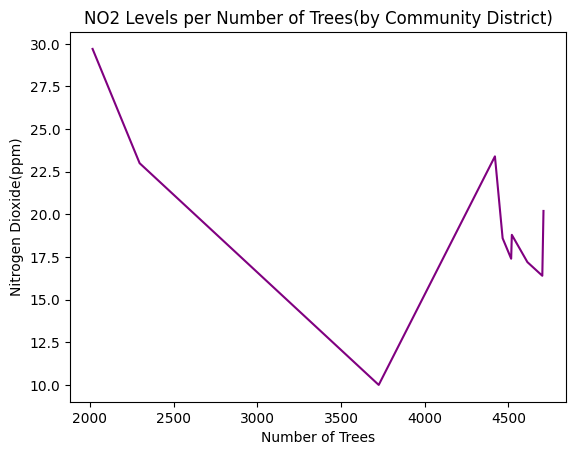

In [130]:
plt.plot(viz_summer['count'], viz_summer['NO2_value'], color='purple')
plt.title('NO2 Levels per Number of Trees(by Community District)')
plt.xlabel('Number of Trees')
plt.ylabel('Nitrogen Dioxide(ppm)')
plt.show()

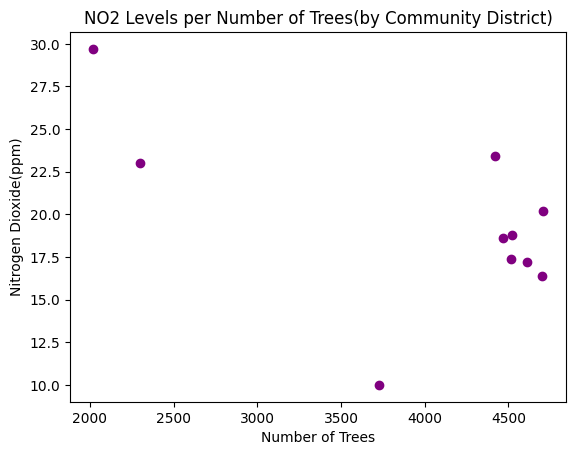

In [131]:
plt.scatter(viz_summer['count'], viz_summer['NO2_value'], color='purple')
plt.title('NO2 Levels per Number of Trees(by Community District)')
plt.xlabel('Number of Trees')
plt.ylabel('Nitrogen Dioxide(ppm)')
plt.show()

In [132]:
viz_winter = pd.read_sql_query(("""SELECT tree.cb_num, tree.tree_count AS count, air.Name, air.Data_Value as NO2_value
                 FROM air
                 LEFT JOIN tree
                 ON air.Geo_Join_ID = tree.cb_num
                 WHERE air.Time_Period = 'Winter 2015-16' AND
                 air.Name = 'Nitrogen dioxide (NO2)'
                 ORDER BY tree_count ASC;
                 """), conn)
print(viz_winter)

    cb_num  count                    Name  NO2_value
0      105   2016  Nitrogen dioxide (NO2)       33.4
1      101   2297  Nitrogen dioxide (NO2)       29.1
2      313   3725  Nitrogen dioxide (NO2)       20.3
3      104   4419  Nitrogen dioxide (NO2)       29.6
4      111   4465  Nitrogen dioxide (NO2)       25.9
5      201   4516  Nitrogen dioxide (NO2)       24.8
6      205   4520  Nitrogen dioxide (NO2)       24.8
7      203   4613  Nitrogen dioxide (NO2)       23.9
8      202   4702  Nitrogen dioxide (NO2)       23.9
9      103   4709  Nitrogen dioxide (NO2)       27.5
10     109   4755  Nitrogen dioxide (NO2)       25.5
11     102   4833  Nitrogen dioxide (NO2)       29.0
12     106   4864  Nitrogen dioxide (NO2)       31.1
13     206   4894  Nitrogen dioxide (NO2)       23.6
14     316   5042  Nitrogen dioxide (NO2)       24.2
15     207   5093  Nitrogen dioxide (NO2)       22.7
16     309   5130  Nitrogen dioxide (NO2)       24.7
17     308   5529  Nitrogen dioxide (NO2)     

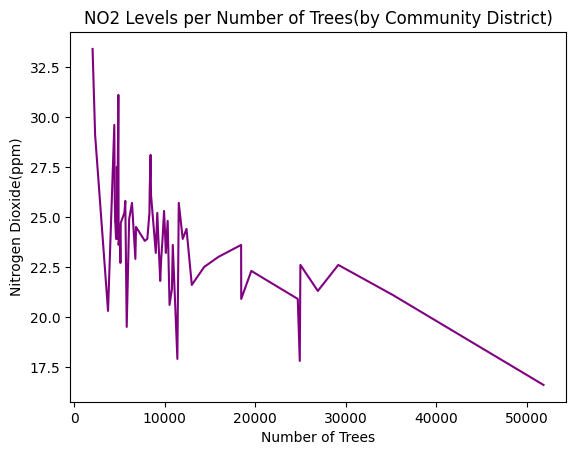

In [133]:
plt.plot(viz_winter['count'], viz_winter['NO2_value'], color='purple')
plt.title('NO2 Levels per Number of Trees(by Community District)')
plt.xlabel('Number of Trees')
plt.ylabel('Nitrogen Dioxide(ppm)')
plt.show()

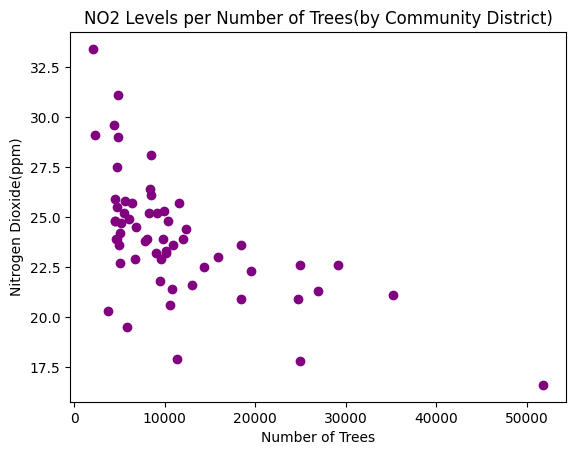

In [134]:
plt.scatter(viz_winter['count'], viz_winter['NO2_value'], color='purple')
plt.title('NO2 Levels per Number of Trees(by Community District)')
plt.xlabel('Number of Trees')
plt.ylabel('Nitrogen Dioxide(ppm)')
plt.show()

In [135]:
tree_area_total = pd.read_sql_query(("""
                           SELECT (tree.tree_count * ((tree.dbh_mean * 2 * 3.14159) / 576)) AS tree_area_sqft, air.Data_Value AS NO2_value
                           FROM air
                           LEFT JOIN tree
                           ON air.Geo_Join_ID = tree.cb_num 
                           WHERE air.Time_Period = 'Summer 2015' AND
                           air.Name = 'Nitrogen dioxide (NO2)'
                           ORDER BY tree_area_sqft ASC;
                           """), conn)
print(tree_area_total)

    tree_area_sqft  NO2_value
0       140.193454       29.7
1       177.799944       23.0
2       354.950364       18.8
3       376.525910       16.4
4       382.786150       23.4
5       383.848542       17.4
6       400.359648       18.6
7       422.285285       17.2
8       430.818672       17.4
9       434.001288       20.2
10      438.759586       10.0
11      463.832725       25.6
12      469.100844       22.4
13      492.288298       18.9
14      526.133946       19.1
15      528.003890       17.3
16      543.839990       18.4
17      574.632263       16.9
18      586.131181       15.0
19      663.159171       15.5
20      677.846377       16.6
21      721.318881       15.9
22      767.439353       14.3
23      830.894792       17.1
24      858.122603       21.7
25      873.069590       19.8
26      892.355026       15.1
27      976.475243        6.9
28      980.173898       16.4
29     1028.863264       15.8
30     1051.285119       18.0
31     1060.230175       16.6
32     116

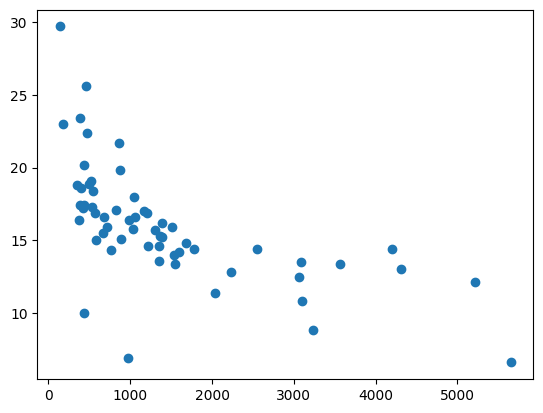

In [136]:
plt.scatter(tree_area_total['tree_area_sqft'], tree_area_total['NO2_value'])
plt.show()

In [137]:
viz_boro = pd.read_sql_query(""" 
                             SELECT boroname, avg_health_score, total_trees FROM boro
                             ORDER BY total_trees DESC;
                             """, conn)
viz_boro

,boroname,avg_health_score,total_trees
0,Queens,2.7757,237970
1,Brooklyn,2.7762,169744
2,Staten Island,2.7732,101442
3,Bronx,2.7881,80584
4,Manhattan,2.6972,61495


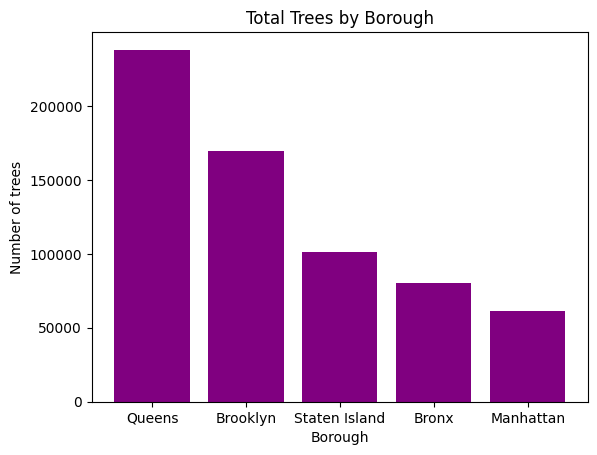

In [138]:
plt.bar(viz_boro['boroname'], viz_boro['total_trees'], color='purple')
plt.title("Total Trees by Borough")
plt.xlabel('Borough')
plt.ylabel('Number of trees')
plt.show()